In [1]:
import pandas as pd
import uproot as up
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import Latex

def minsquares(f, data, xcolumn=0, ycolumn=1, x_label='X Values', y_label='Y values', data_color="b", line_color="g", leg='Data', name="name"):
    """
    Para hacer los ajustes de mínimos cuadrados
    """
    p0 = [58.345, -408.32]
    varnames = f.__code__.co_varnames
    lbl = ""
    
    for nm in range(len(varnames)):
        if nm == 0:
            pass
        else:
            lbl = lbl + " " + str(varnames[nm]) + "=%5.3f,"
            
    # Temporary patch
    p0 = np.polyfit(data["lgE"], data["Xmax"], 1)
    
    plt.figure(figsize=(8,5), dpi=300)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # curve_fit not working???????
    popt, pcov = curve_fit(f, data.iloc[:, xcolumn], data.iloc[:, ycolumn], p0)
    plt.plot(data.iloc[:, xcolumn], data.iloc[:, ycolumn], linestyle="none", marker=".", color=data_color, label=leg)
    plt.plot(data.iloc[:, xcolumn], f(data.iloc[:, xcolumn], *popt), linestyle='-', marker="", color=line_color, label='Least Squares: ' + lbl % tuple(popt))
    plt.legend()
    plt.grid()
    plt.savefig(name, bbox_inches="tight")
    plt.show()
    

In [2]:
rootPo = up.open("rootfiles/PoQ02-16.875-18.625.root")["Shower"]

lgEPo = pd.DataFrame({"lgE": rootPo["lgE"].array()})
xmaxPo = pd.DataFrame({"Xmax": rootPo["Xmax"].array()})
dfPo = lgEPo.join(xmaxPo)
dfPo = dfPo[dfPo['Xmax'] < 1100].sort_values(by="lgE").reset_index().drop(columns="index")

rootFe = up.open("rootfiles/FeQ02-16.875-18.625.root")["Shower"]

lgEFe = pd.DataFrame({"lgE": rootFe["lgE"].array()})
xmaxFe = pd.DataFrame({"Xmax": rootFe["Xmax"].array()})
dfFe = lgEFe.join(xmaxFe)
dfFe = dfFe[dfFe['Xmax'] < 900].sort_values(by="lgE").reset_index().drop(columns="index")

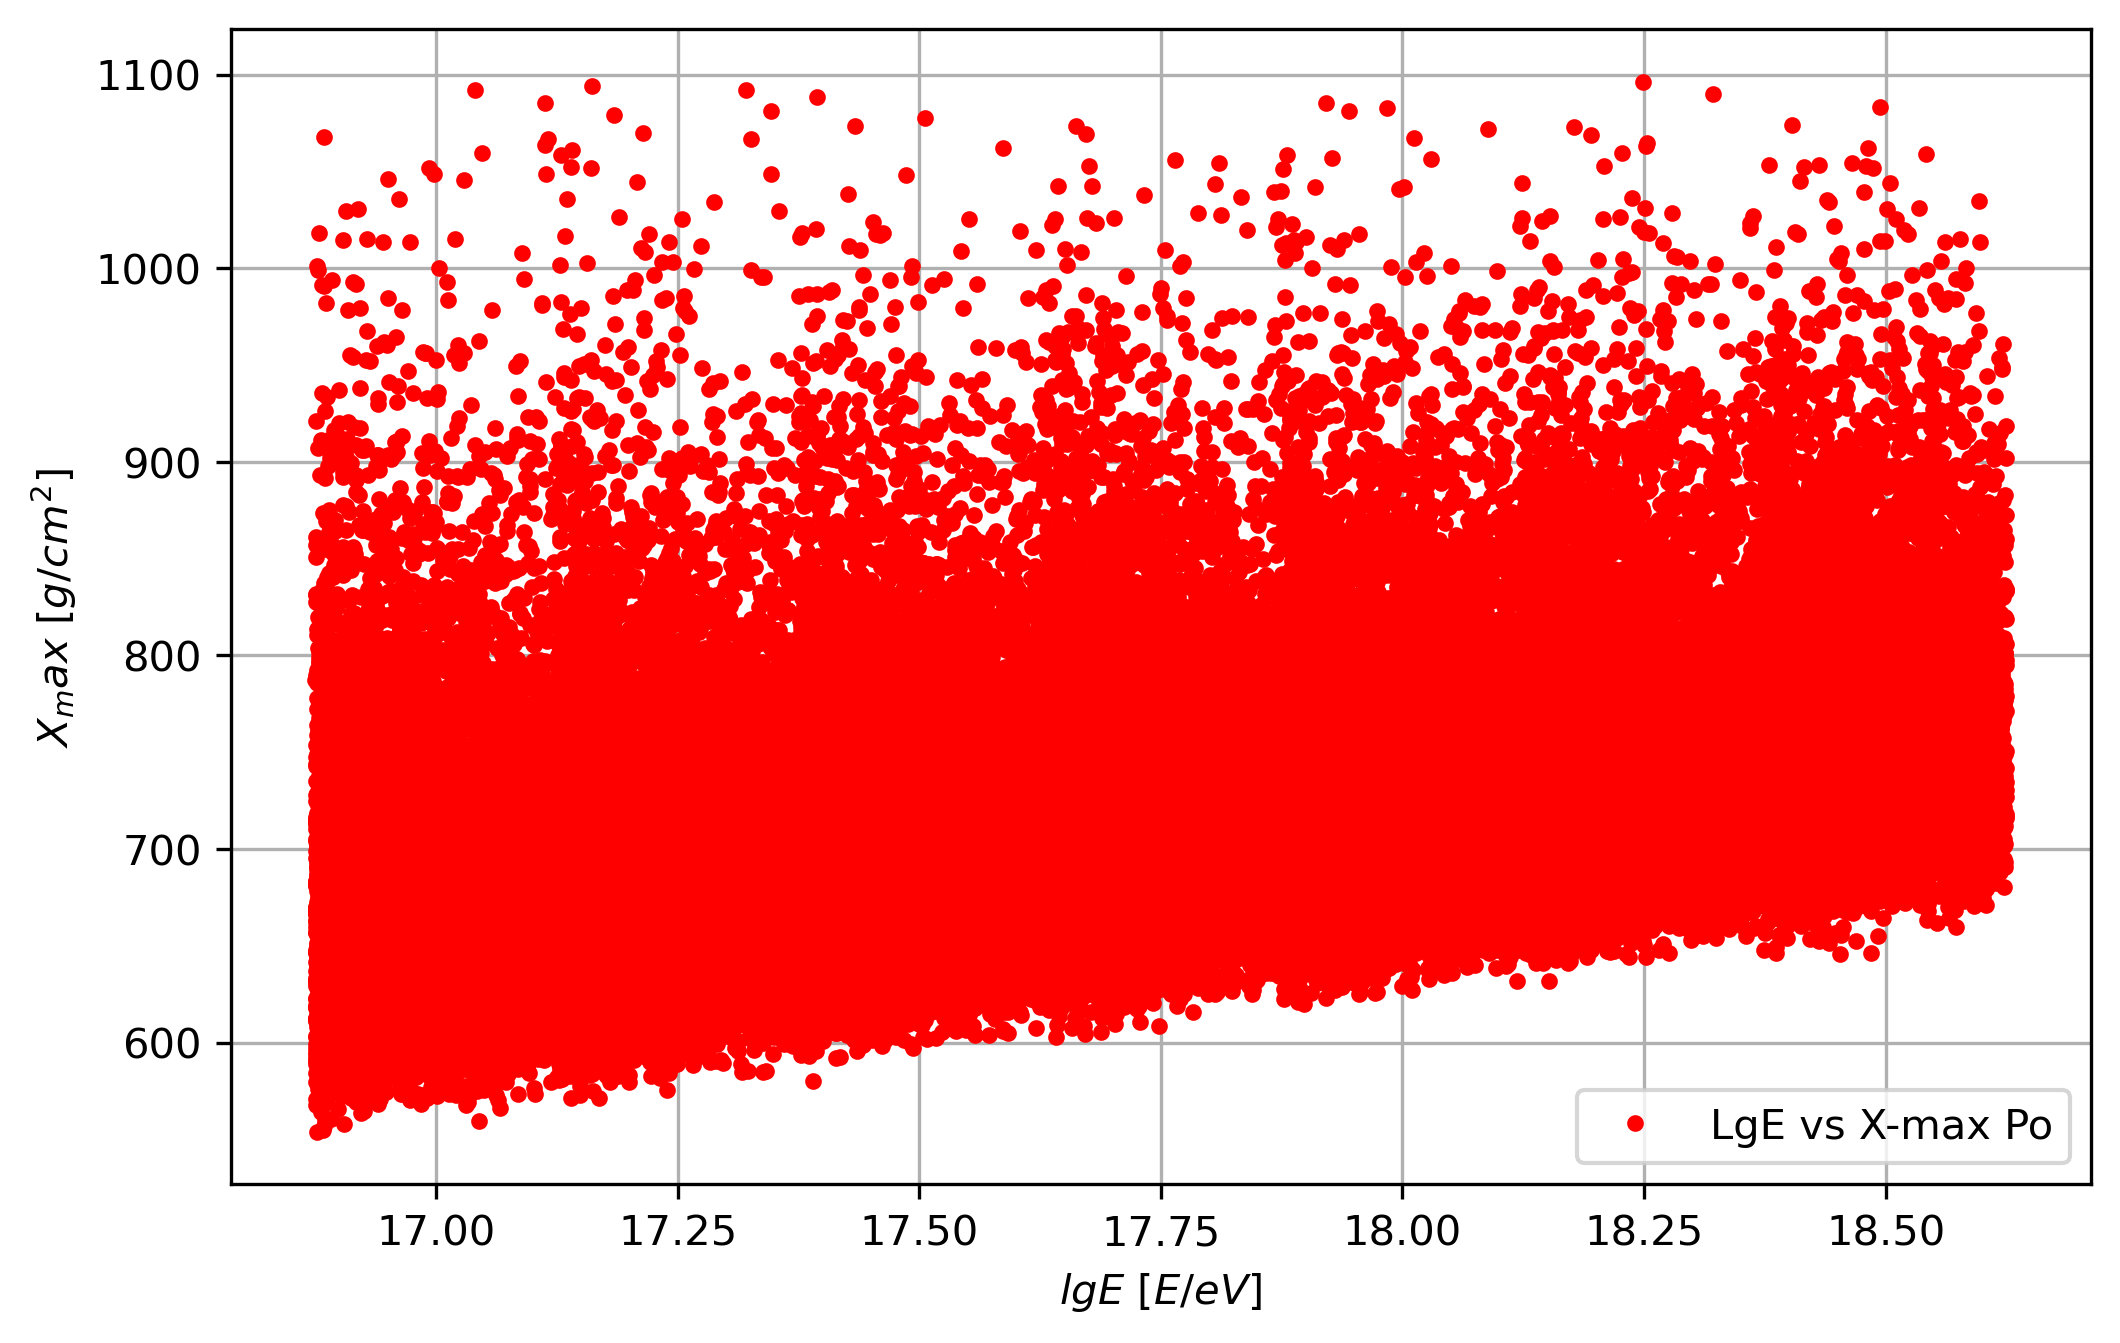

In [10]:
plt.figure(figsize=(8, 5), dpi=300)
plt.grid()
plt.plot(dfPo.iloc[:, 0], dfPo.iloc[:, 1], 'r.', label="LgE vs X-max Po")
plt.xlabel("$lgE \ [E/eV]$")
plt.legend()
plt.ylabel("$X_max \ [g/cm^2]$")
plt.savefig("images/LgE_vs_Xmax_Po.png", bbox_inches="tight")

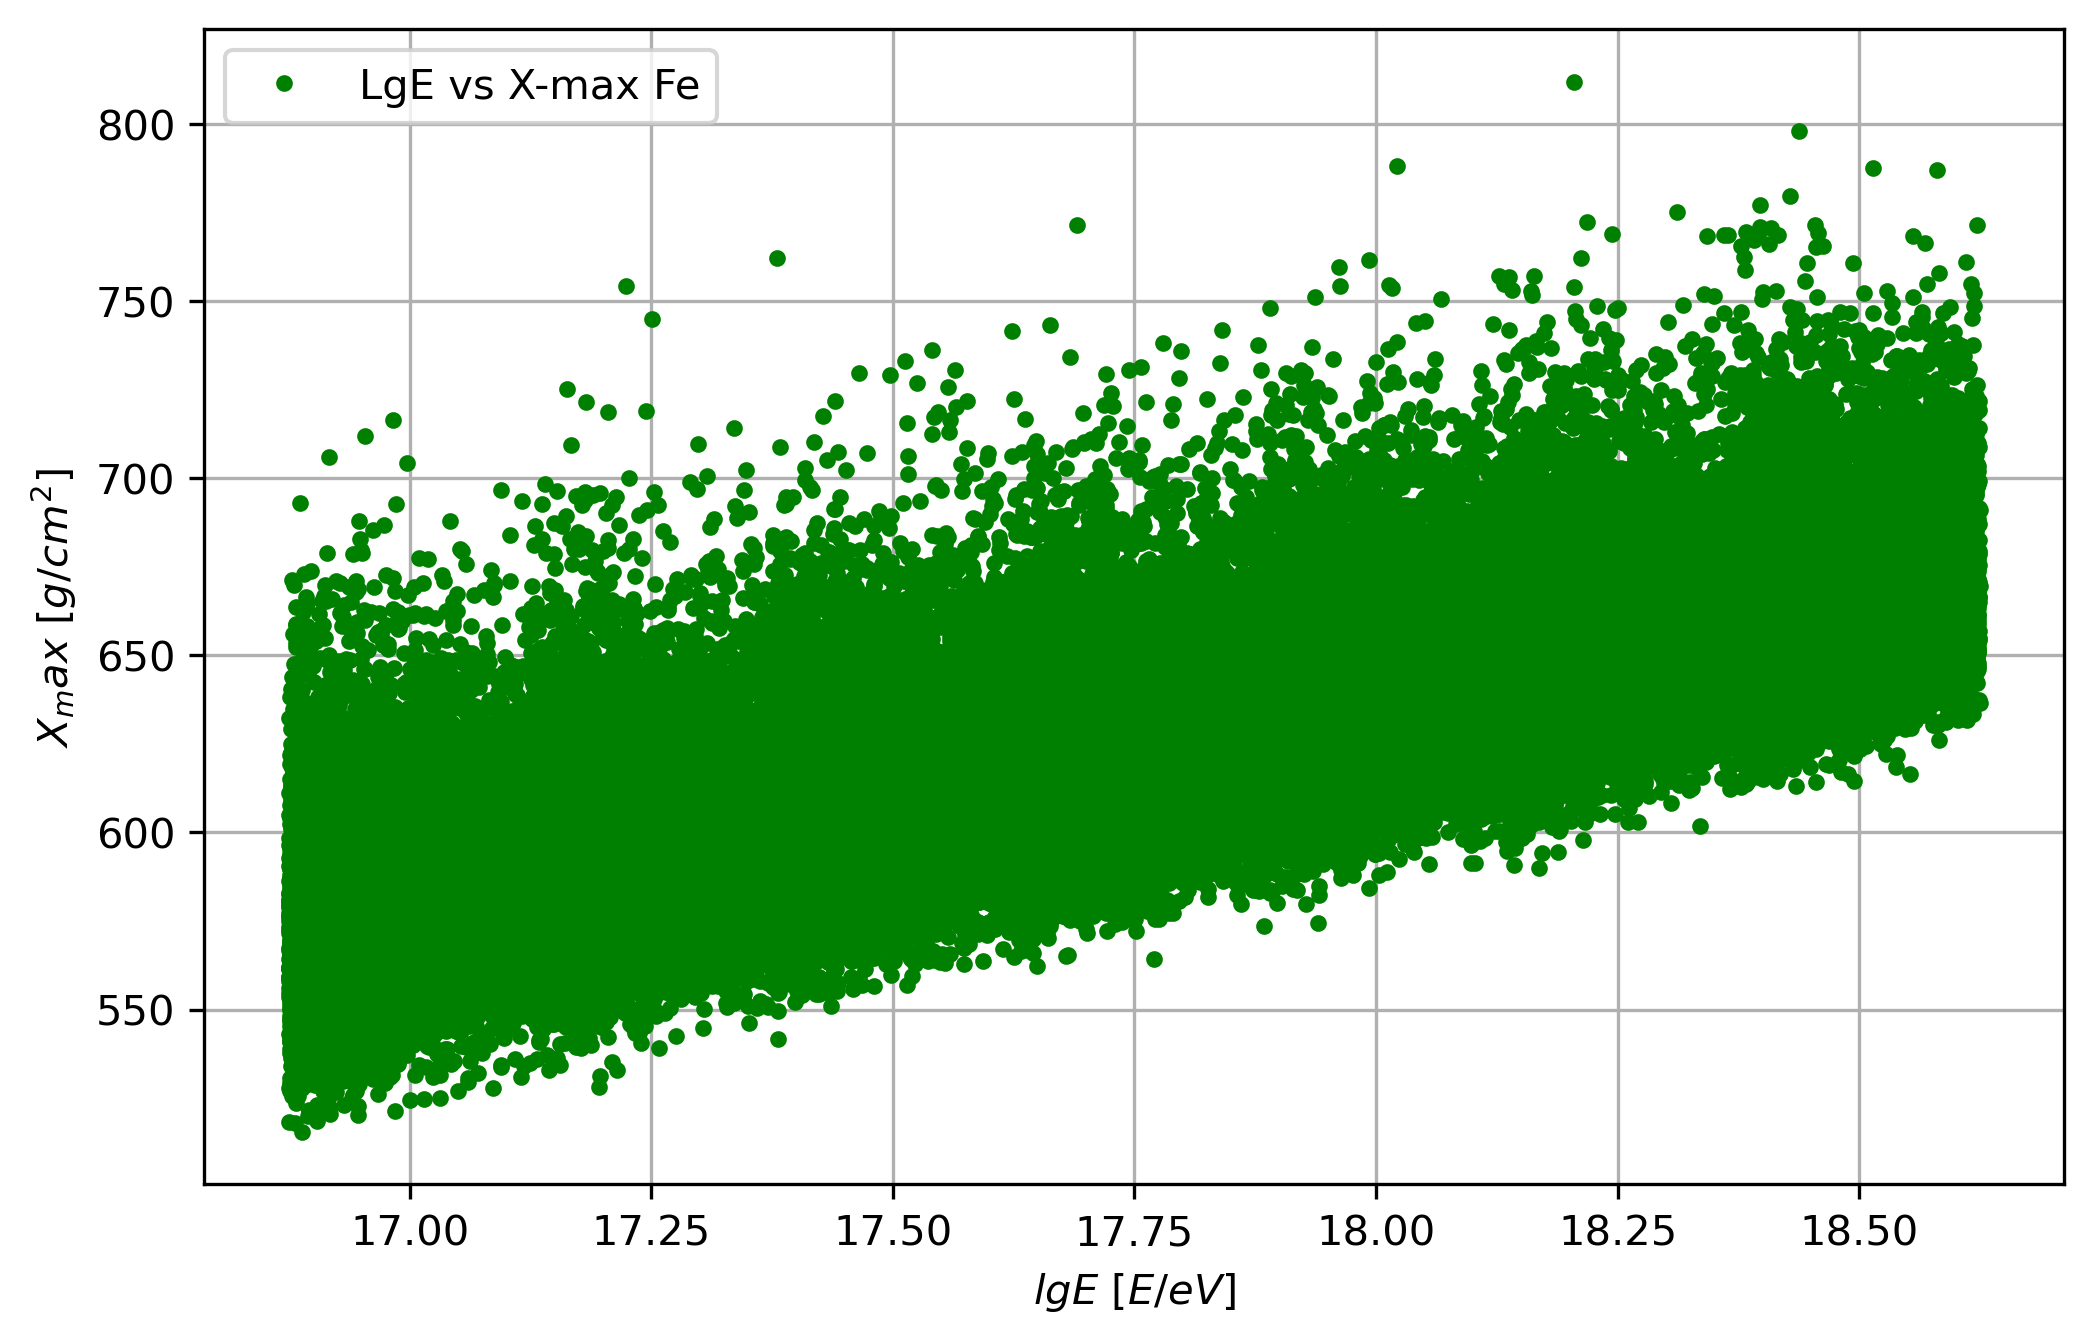

In [11]:
plt.figure(figsize=(8, 5), dpi=300)
plt.grid()
plt.plot(dfFe.iloc[:, 0], dfFe.iloc[:, 1], linestyle='none', marker=".", color="g", label="LgE vs X-max Fe")
plt.xlabel("$lgE \ [E/eV]$")
plt.legend()
plt.ylabel("$X_max \ [g/cm^2]$")
plt.savefig("images/LgE_vs_Xmax_Fe.png")

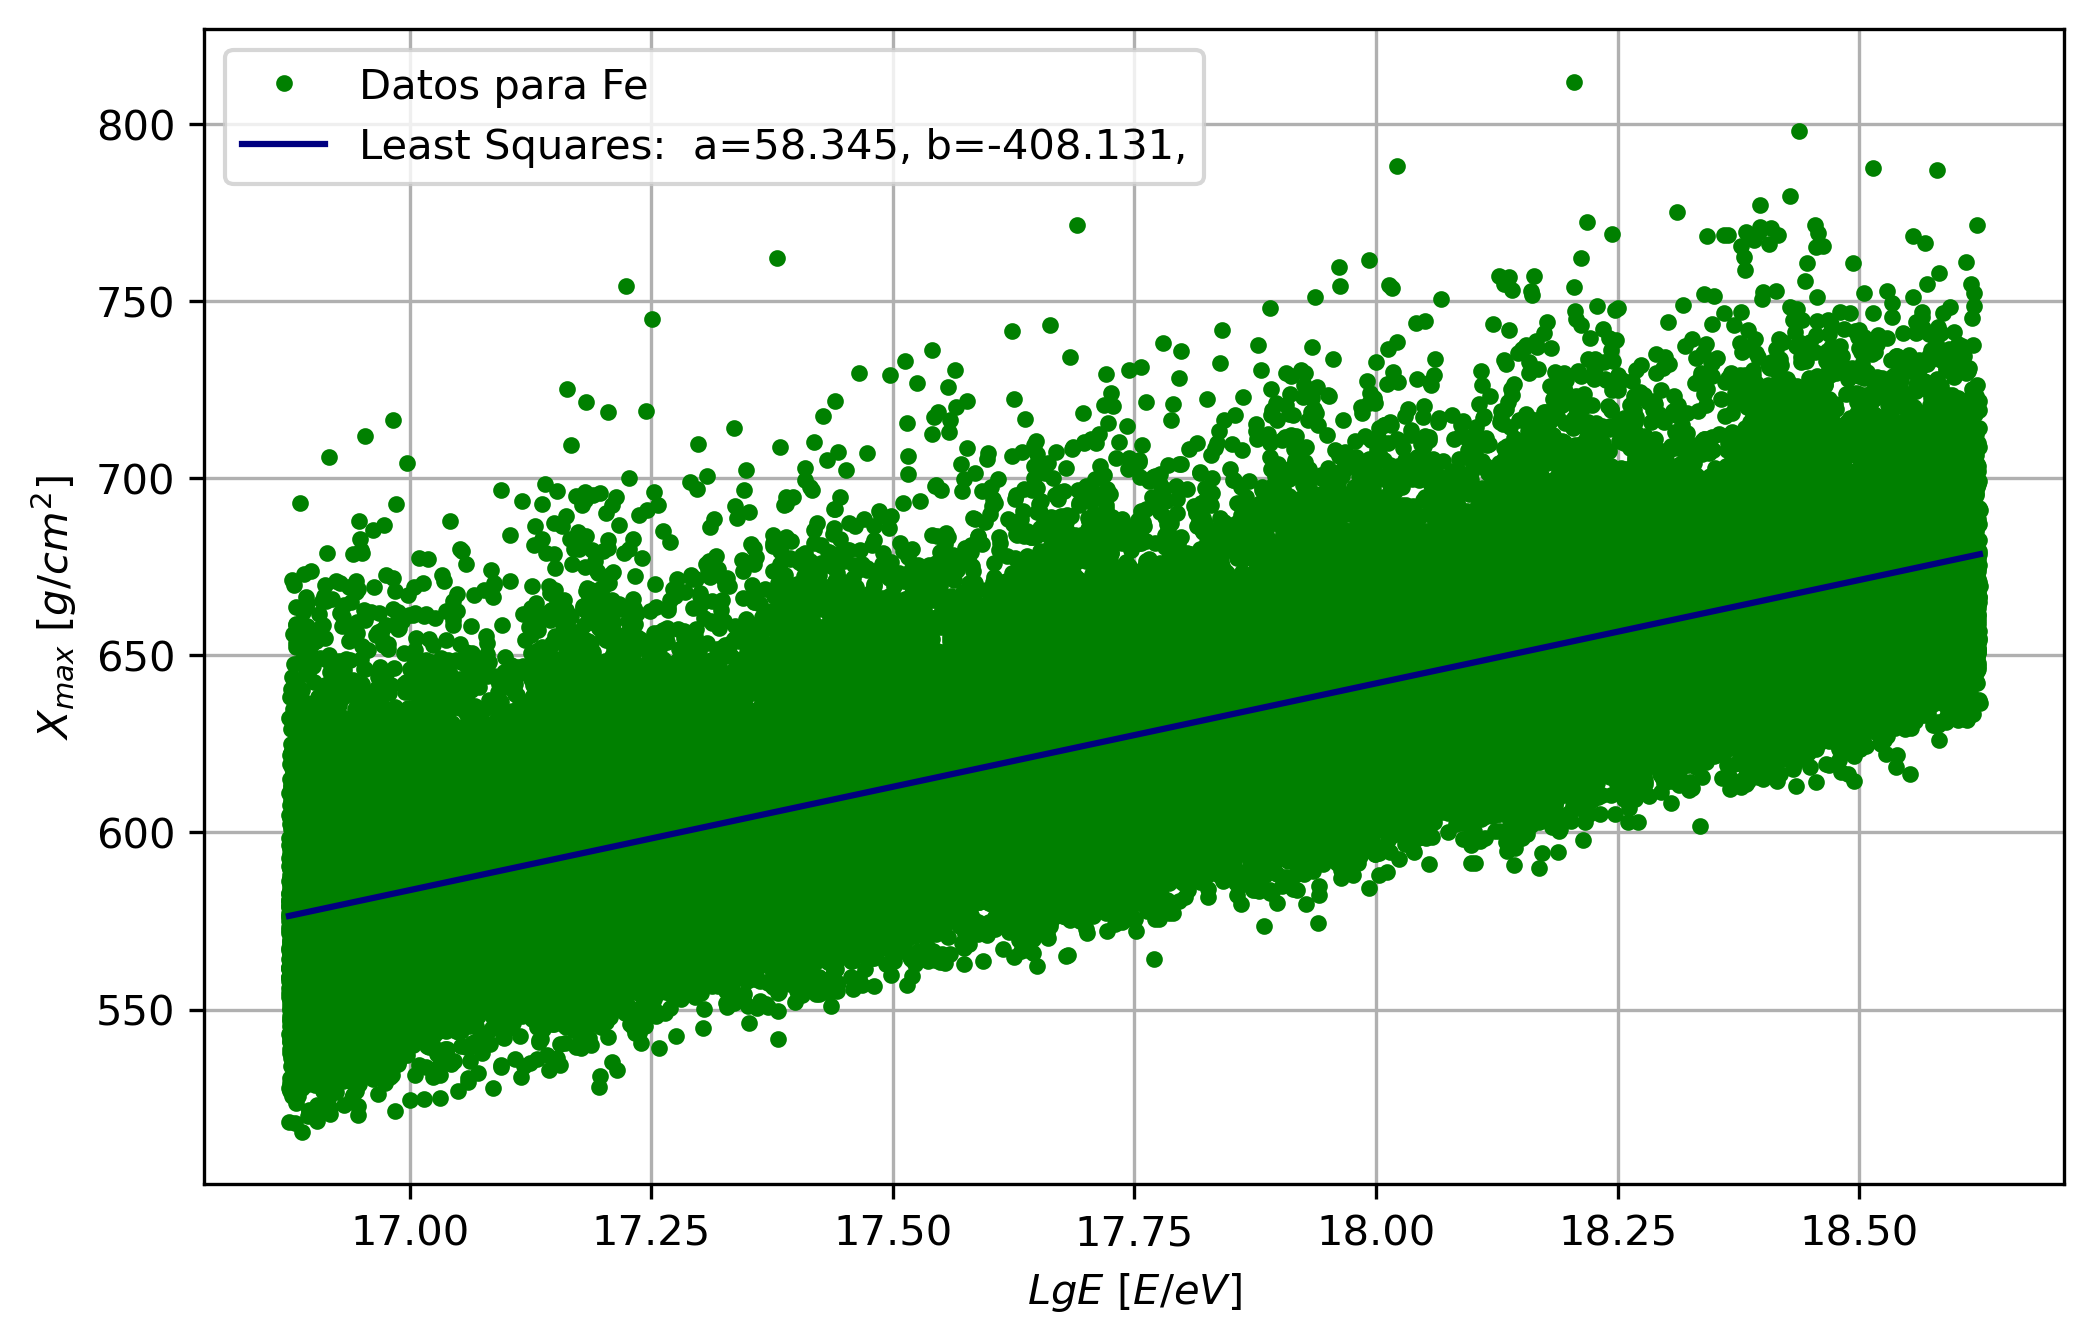

In [5]:
def f(x, a, b):
    return a*x + b

minsquares(f, dfFe, x_label="$LgE \ [E/eV]$", y_label="$X_{max} \ [g/cm^2]$", data_color="g", line_color="navy", leg="Datos para Fe", name="images/Fe_LeastSqrs.png")

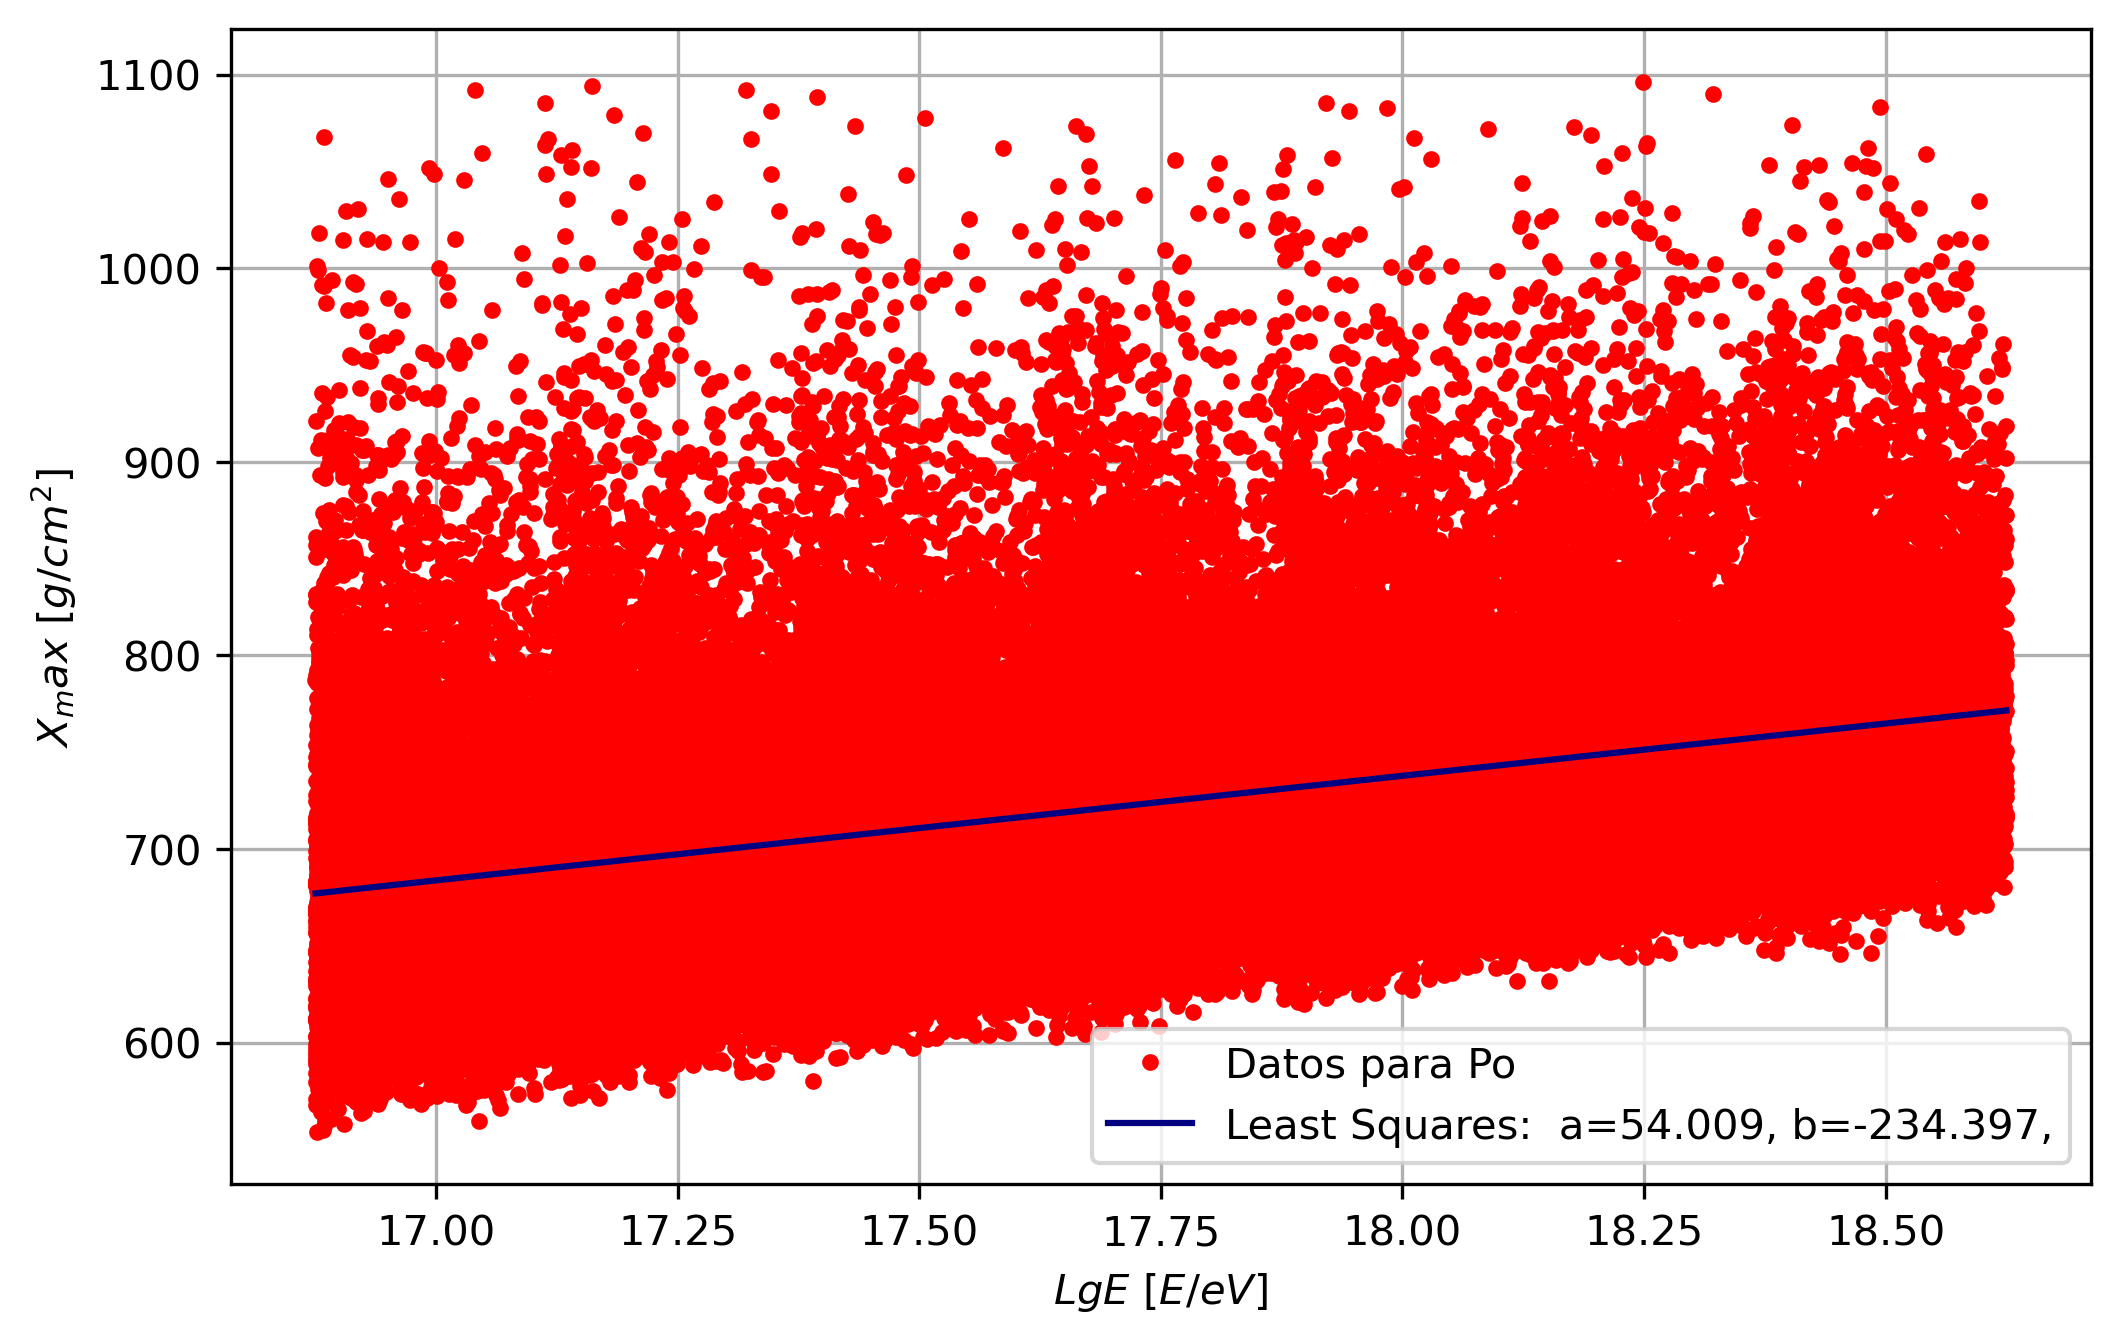

In [6]:
minsquares(f, dfPo, x_label="$LgE \ [E/eV]$", y_label="$X_max \ [g/cm^2]$", data_color="r", line_color="navy", leg="Datos para Po", name="images/Po_LeastSqrs.png")

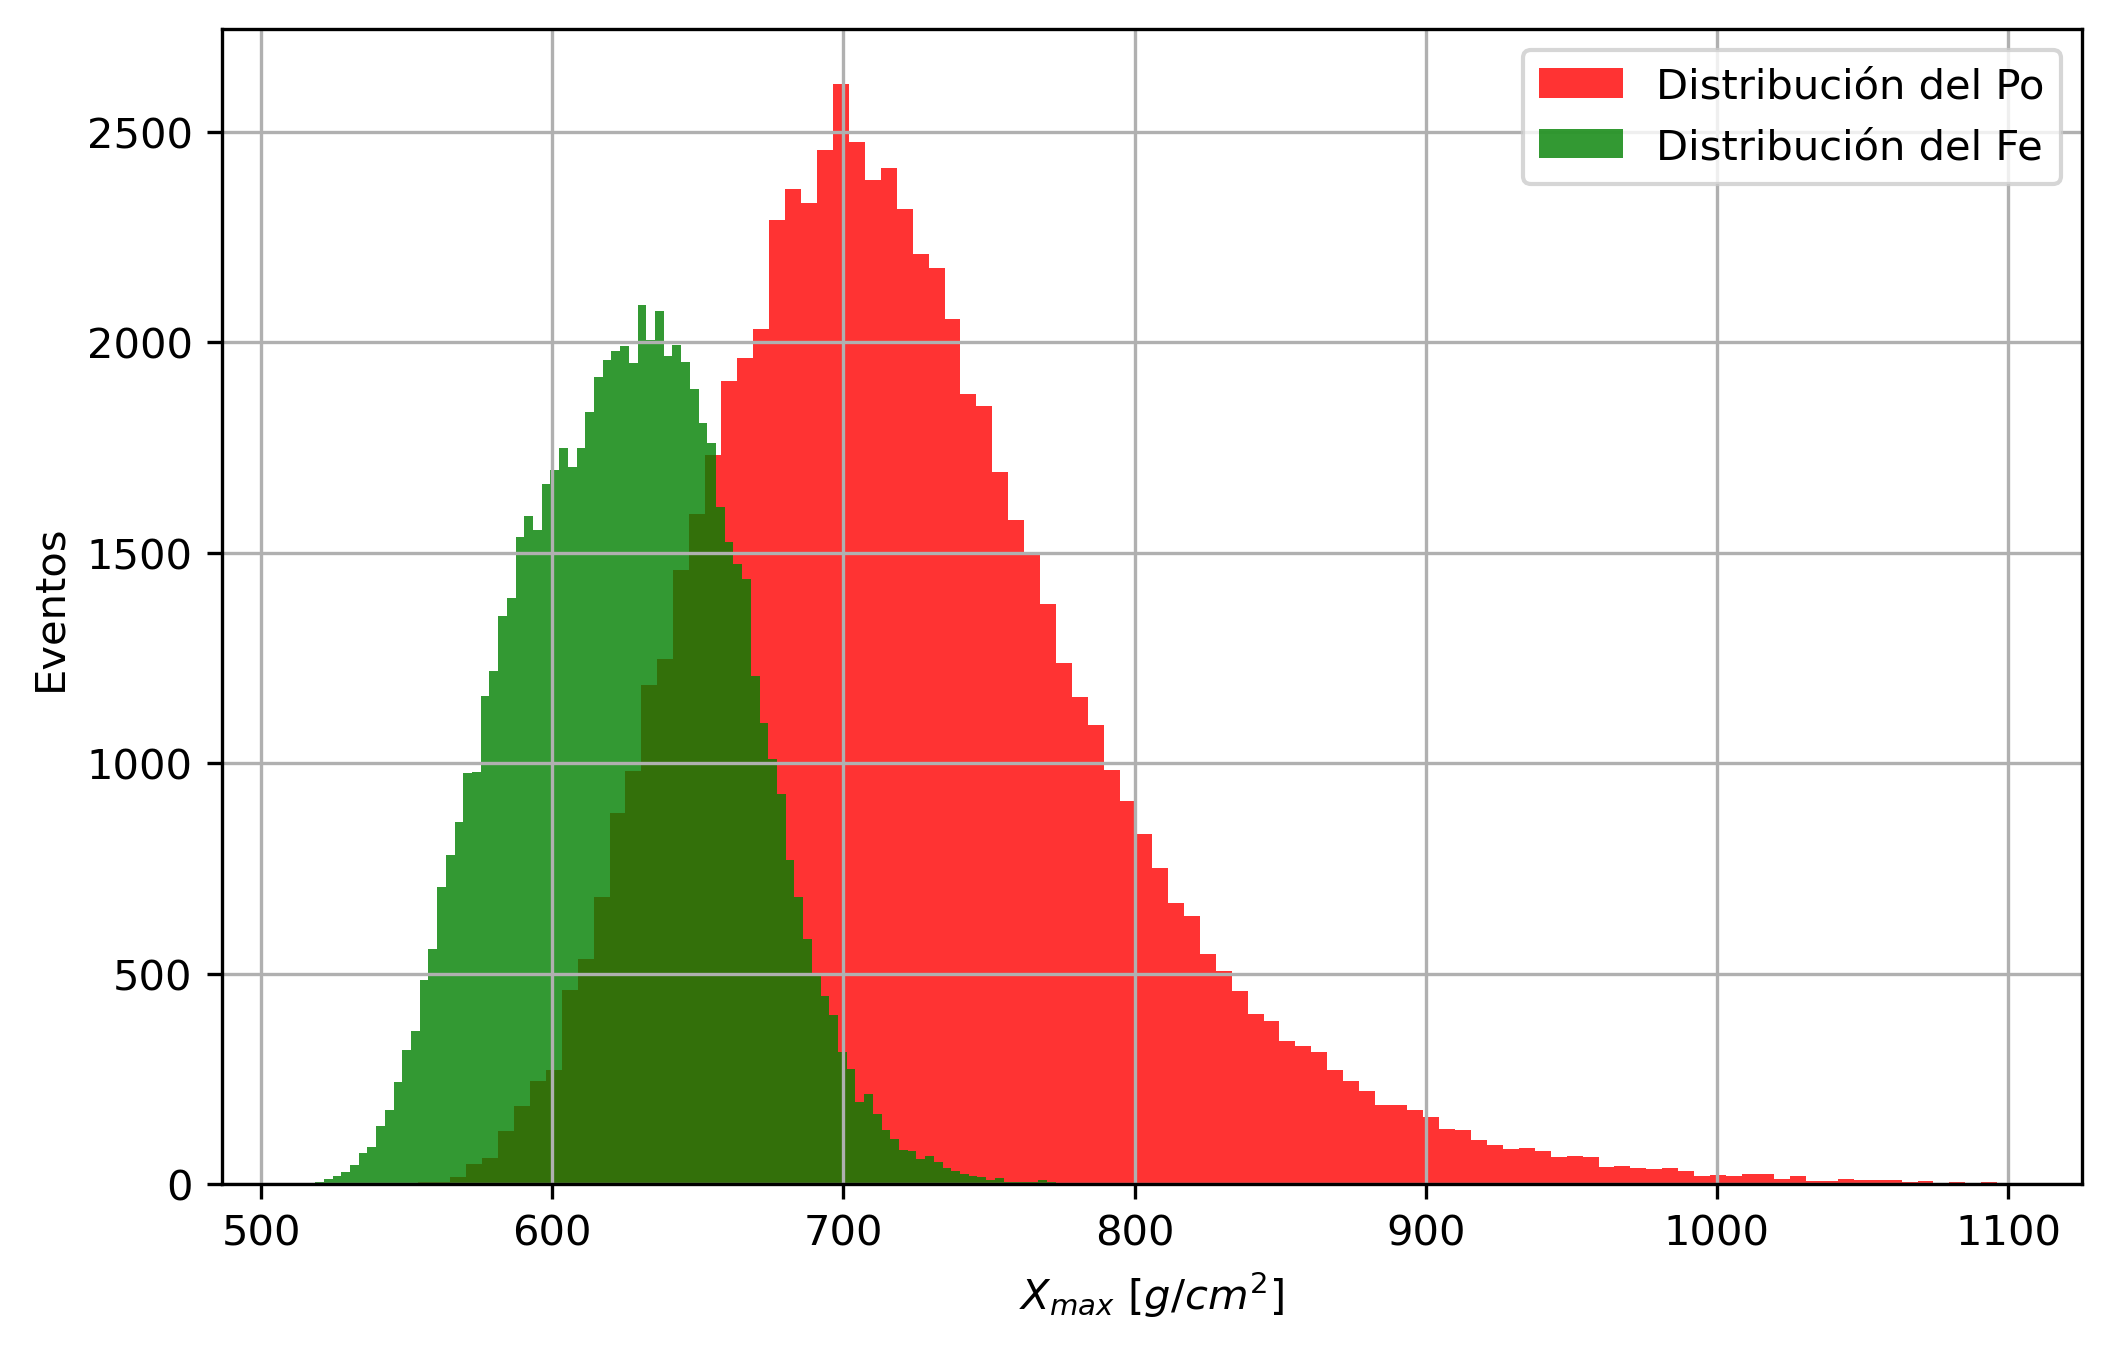

In [8]:
rangexmaxPo = np.linspace(min(dfPo.iloc[:, 1]), max(dfPo.iloc[:, 1]), 100)
rangexmaxFe = np.linspace(min(dfFe.iloc[:, 1]), max(dfFe.iloc[:, 1]), 100)

plt.figure(figsize=(8, 5), dpi=300)
nPo, binsPo, patchesPo = plt.hist(dfPo.iloc[:, 1], bins=rangexmaxPo, alpha=0.8, color="r", label="Distribución del Po")
nFe, binsFe, patchesFe = plt.hist(dfFe.iloc[:, 1], bins=rangexmaxFe, alpha=0.8, color="g", label="Distribución del Fe")
plt.xlabel("$X_{max} \ [g/cm^2]$")
plt.ylabel("Eventos")
plt.legend()
plt.grid()
plt.savefig("images/Hist_Xmax.png", bbox_inches="tight")
plt.show()

In [46]:
# Conseguir los valores promedio para un dividiendo el intervalo en 1750 partes. Se tarda un buen rato (+2 horas jsjs)

diflgEFe = lgEFe.round(3).drop_duplicates().sort_values(by=["lgE"]).reset_index().drop(columns="index")

sigmalgE = 0
for x in range(1, len(diflgEFe)):
    sigmalgE += diflgEFe.iloc[x] - diflgEFe.iloc[x-1]

sigmalgE = sigmalgE/(len(diflgEFe)-1)
sigmalgE = sigmalgE.tolist()[0]


temp = {}

for delta in diflgEFe.iloc[:, 0]:
    temp[delta] = []

In [50]:
for x in range(len(dfFe.iloc[:, 0])):
    for delta in diflgEFe.iloc[:, 0]:
        if delta-sigmalgE <= dfFe.iloc[x, 0] <= delta+sigmalgE:
            temp[delta].append(dfFe.iloc[x, 1]) 


In [62]:
avg = [] 

for x in temp.keys():
    avg.append(np.mean(temp.get(x)))

In [66]:
dfavgFe = pd.DataFrame({"lge": diflgEFe.iloc[:, 0], "Avg X max": avg})

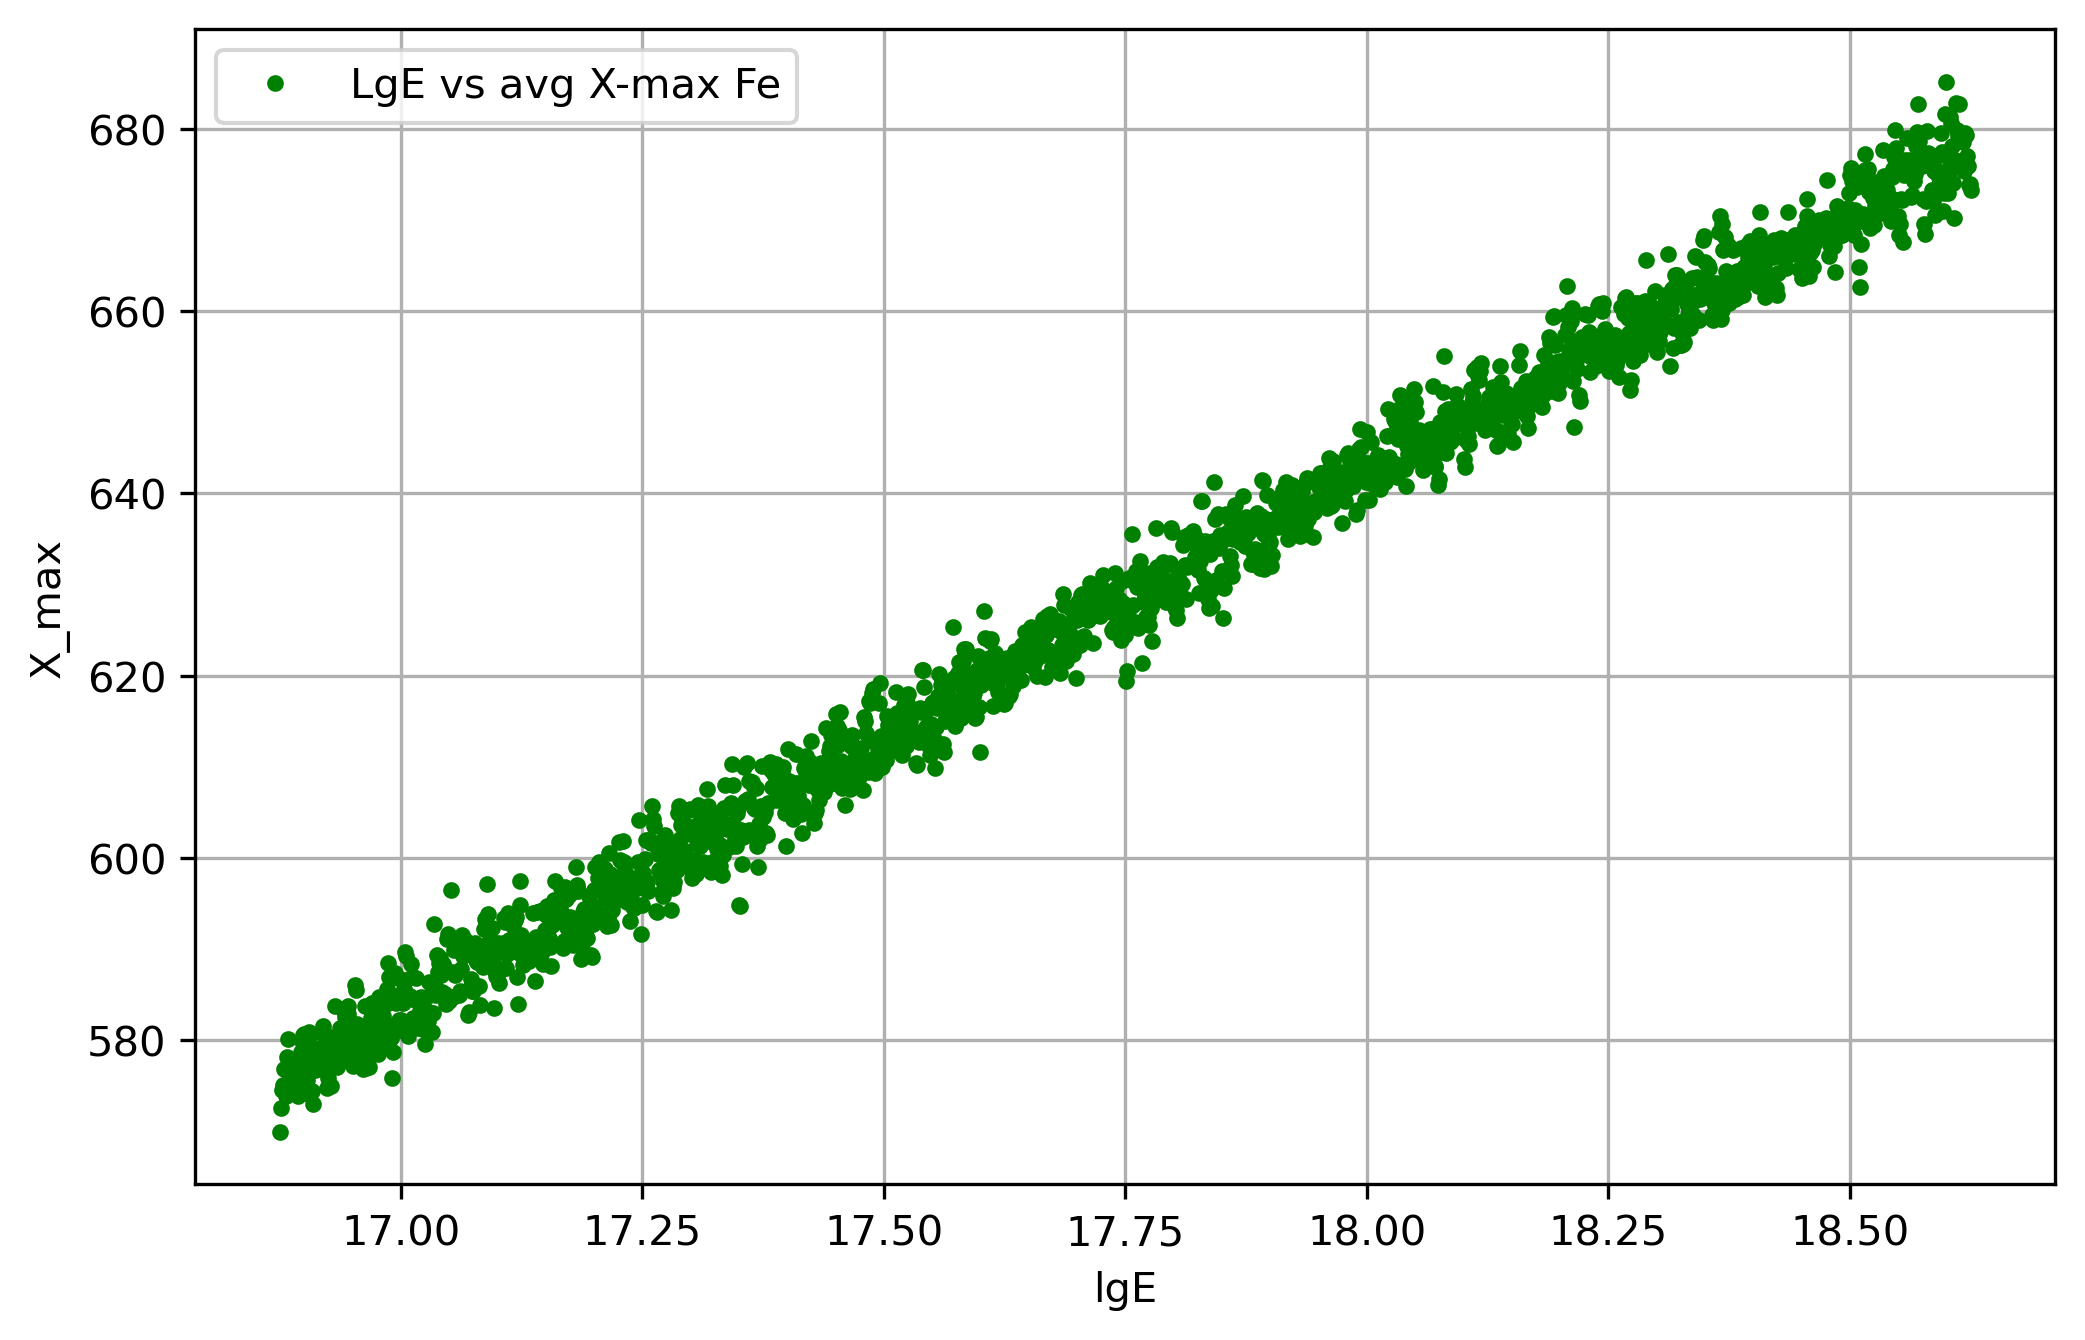

In [70]:
plt.figure(figsize=(8, 5), dpi=300)
plt.grid()
plt.plot(dfavgFe.iloc[:, 0], dfavgFe.iloc[:, 1], linestyle='none', marker=".", color="g", label="LgE vs avg X-max Fe")
plt.xlabel("$lgE [E/eV]$")
plt.legend()
plt.ylabel("$X_max [g/cm^2]$")
plt.savefig("images/LgE_vs_avgXmax_Fe.png")

In [9]:
diflgEPo = lgEPo.round(3).drop_duplicates().sort_values(by=["lgE"]).reset_index().drop(columns="index")

sigmalgEPo = 0
for x in range(1, len(diflgEPo)):
    sigmalgEPo += diflgEPo.iloc[x] - diflgEPo.iloc[x-1]

sigmalgEPo = sigmalgEPo/(len(diflgEPo)-1)
sigmalgEPo = sigmalgEPo.tolist()[0]


temp = {}

for delta in diflgEPo.iloc[:, 0]:
    temp[delta] = []

In [10]:
for x in range(len(dfPo.iloc[:, 0])):
    for delta in diflgEPo.iloc[:, 0]:
        if delta-sigmalgEPo <= dfPo.iloc[x, 0] <= delta+sigmalgEPo:
            temp[delta].append(dfPo.iloc[x, 1])

In [12]:
avgPo = [] 

for x in temp.keys():
    avgPo.append(np.mean(temp.get(x)))
    
dfavgPo = pd.DataFrame({"lge": diflgEPo.iloc[:, 0], "Avg X max": avgPo})

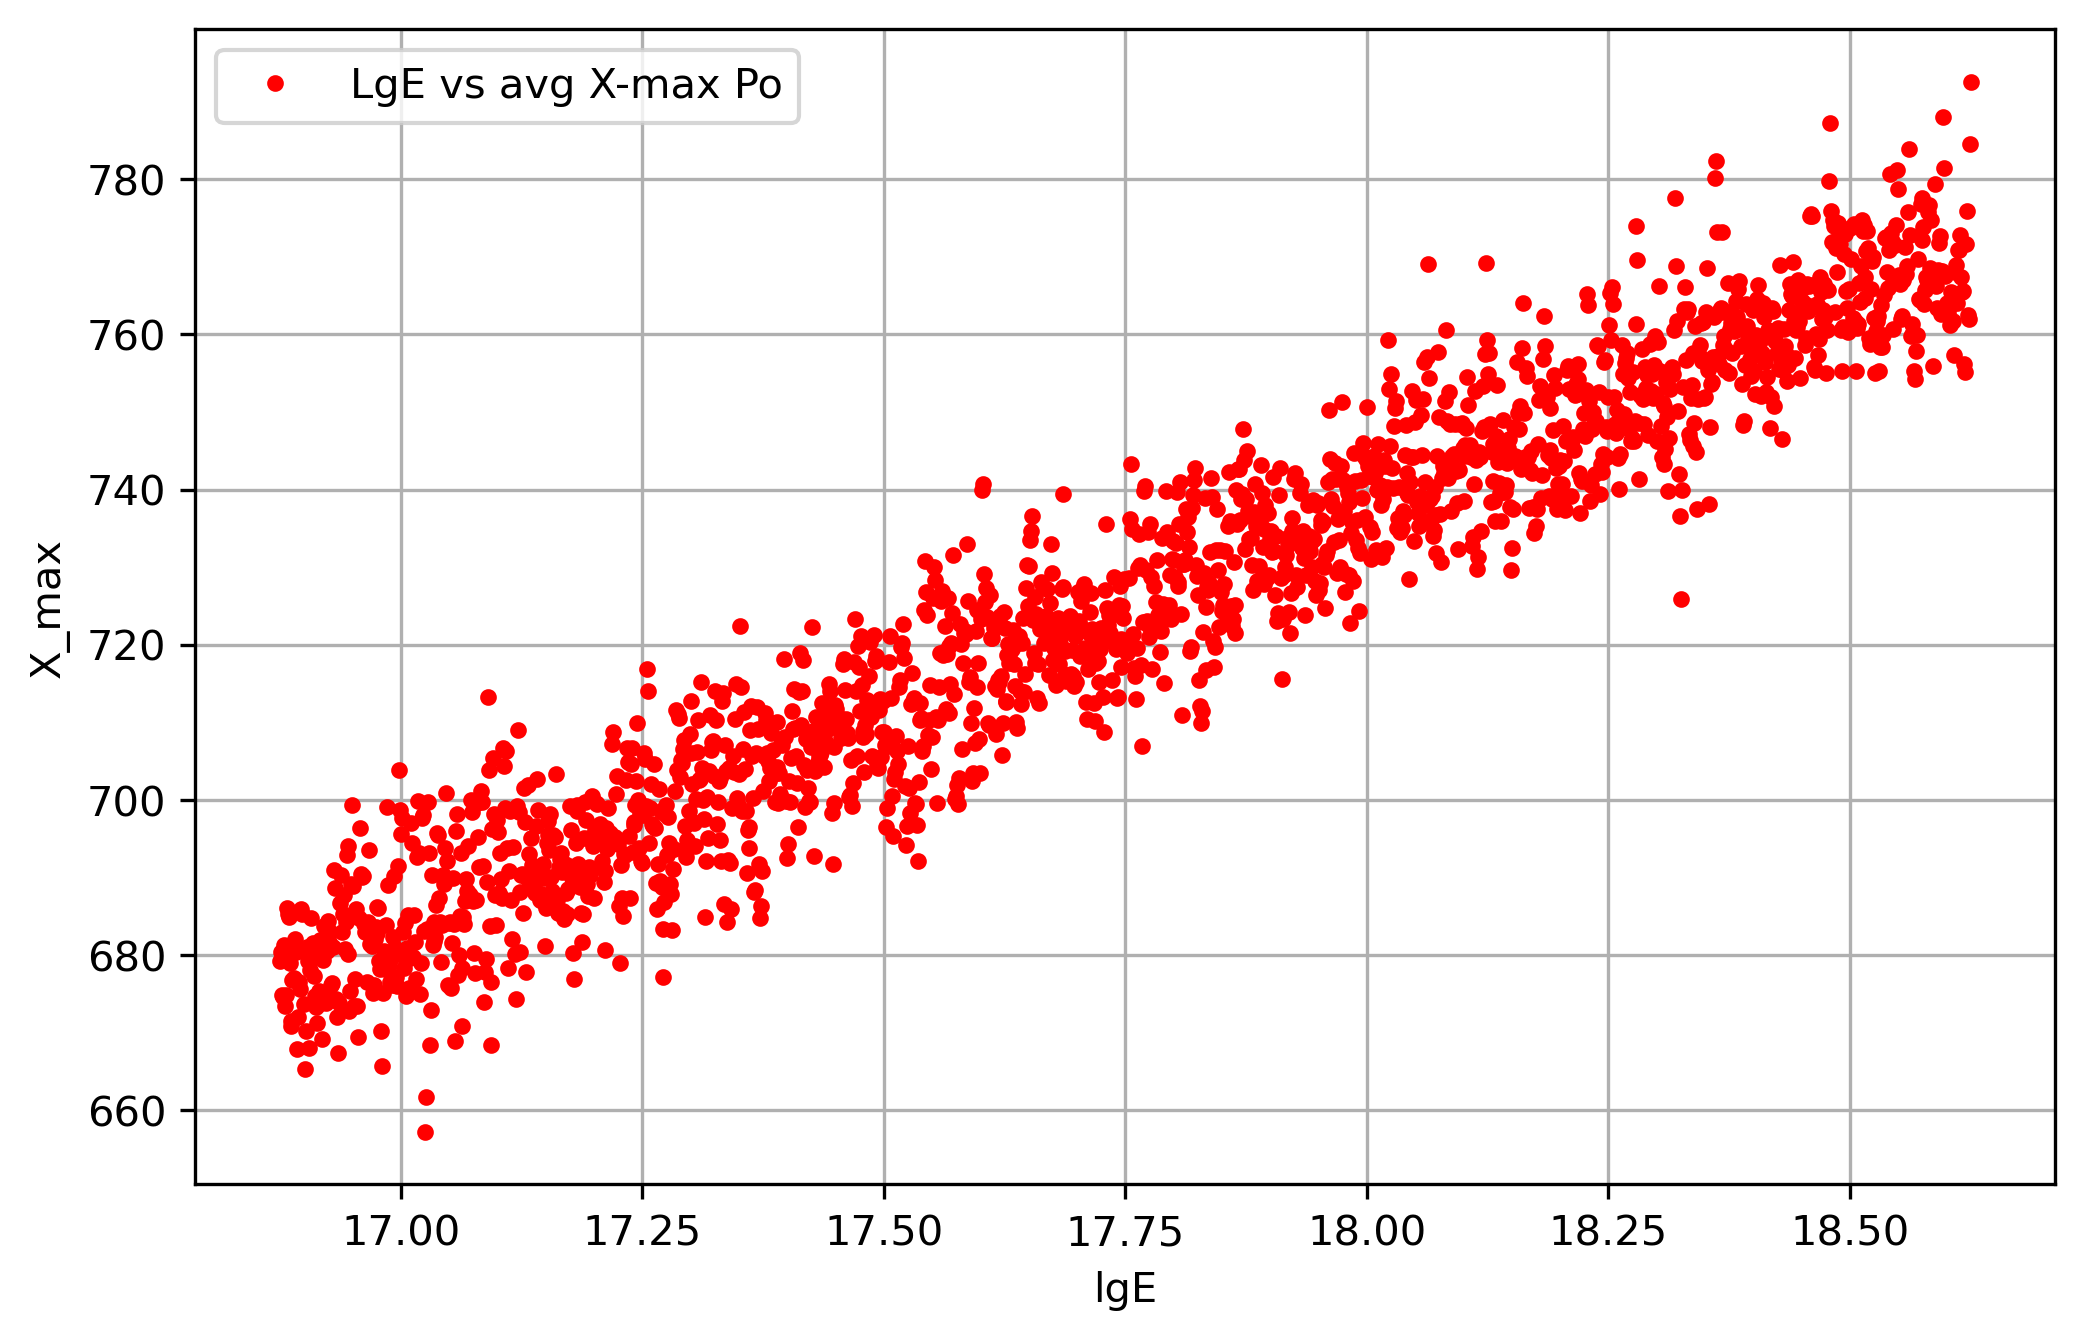

In [13]:
plt.figure(figsize=(8, 5), dpi=300)
plt.grid()
plt.plot(dfavgPo.iloc[:, 0], dfavgPo.iloc[:, 1], linestyle='none', marker=".", color="r", label="LgE vs avg X-max Po")
plt.xlabel("$lgE [E/ev]$")
plt.legend()
plt.ylabel("$X_max [g/cm^2]$")
plt.savefig("images/LgE_vs_avgXmax_Po.png")

# Gaisser-Hillas

In [3]:
# Ya no se va a trabajar en esto...


nmax = pd.DataFrame({"Nmax": rootPo["Nmax"].array()})

In [4]:
dfXPo = pd.DataFrame({"X0": rootPo["X"].array()[0]})
ind = 1

for x in enumerate(rootPo["X"].array()[::100]):
    dfXPo = dfXPo.join(pd.DataFrame({f"X{x[0] + 1}": x[1]}), how="outer")

In [5]:
avglistXPo = []

temp = dfXPo.sum(axis=1).tolist()

for y in range(244):
    n = 0
    for x in range(701):
        if np.isnan(dfXPo.iloc[y, x]) == False:
            n += 1
    temp[y] = temp[y]/n
    avglistXPo.append(temp[y])
    
dfXPo = dfXPo.join(pd.DataFrame({"Xavg": avglistXPo}), how="left")